# pycaret을 이용한 가스공급량 예측
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'
* 특성
    * 습도, 기압(3개) : 'month', 'weekday', '시간'
    * 기온(5개) : 'month', 'weekday', '시간', '습도', '기압'
    * 공급량 예측(7개) : 'month', 'weekday', '시간', '구분', '기온', '습도', '기압'
    * PCA 적용
* 공급량 log적용
* 2개 모델('lightgbm', 'catboost') 예측 평균

In [ ]:
# 제출 파일명 : sub19_pycaret07.csv
# 제출 점수 : 

## 데이터 가져오기
* 2019년 test 데이터 : '../data/test.csv'
* 2019년 제출 파일 : '../data/sample_submission.csv'
* 2013-2018년 가스공급량과 기온 자료 : '../2013-2018년_가스공급량_기온_습도_기압01.csv'

In [1]:
import time
import datetime
import pandas as pd

### 2013-2018년 가스공급량과 기온 자료

In [2]:
total = pd.read_csv('../2013-2018년_가스공급량_기온_습도_기압01.csv')
total.head()

,year,month,day,weekday,시간,구분,공급량,기온,습도,기압
0,2013,1,1,1,1,0,2497.129,-8.5,57.0,1010.0
1,2013,1,1,1,1,1,2169.093,-8.5,57.0,1010.0
2,2013,1,1,1,1,2,226.178,-8.5,57.0,1010.0
3,2013,1,1,1,1,3,1434.516,-8.5,57.0,1010.0
4,2013,1,1,1,1,4,3272.837,-8.5,57.0,1010.0


#### 2019년 데이터

In [3]:
test2019 = pd.read_csv('../data/test.csv')
test2019.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [4]:
test2019[['연월일', '시간', '구분']] = test2019['일자|시간|구분'].str.split(' ').tolist()
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,A
1,2019-01-01 02 A,2019-01-01,02,A
2,2019-01-01 03 A,2019-01-01,03,A
3,2019-01-01 04 A,2019-01-01,04,A
4,2019-01-01 05 A,2019-01-01,05,A


In [5]:
# 구분 열을 숫자로 바꾸기
d_map = {}
for i, d in enumerate(test2019['구분'].unique()):
    d_map[d] = i
test2019['구분'] = test2019['구분'].map(d_map)
test2019.head()

,일자|시간|구분,연월일,시간,구분
0,2019-01-01 01 A,2019-01-01,01,0
1,2019-01-01 02 A,2019-01-01,02,0
2,2019-01-01 03 A,2019-01-01,03,0
3,2019-01-01 04 A,2019-01-01,04,0
4,2019-01-01 05 A,2019-01-01,05,0


In [6]:
# 연월일 열은 object형이므로 년, 월, 일로 나눈다.
test2019['연월일'] = pd.to_datetime(test2019['연월일'])
test2019['year'] = test2019['연월일'].dt.year
test2019['month'] = test2019['연월일'].dt.month
test2019['day'] = test2019['연월일'].dt.day
test2019['weekday'] = test2019['연월일'].dt.weekday
test2019.head()

,일자|시간|구분,연월일,시간,구분,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,01,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,02,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,03,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,04,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,05,0,2019,1,1,1


### 상관계수 확인

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

import platform
from matplotlib import font_manager, rc

path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")

<AxesSubplot:>

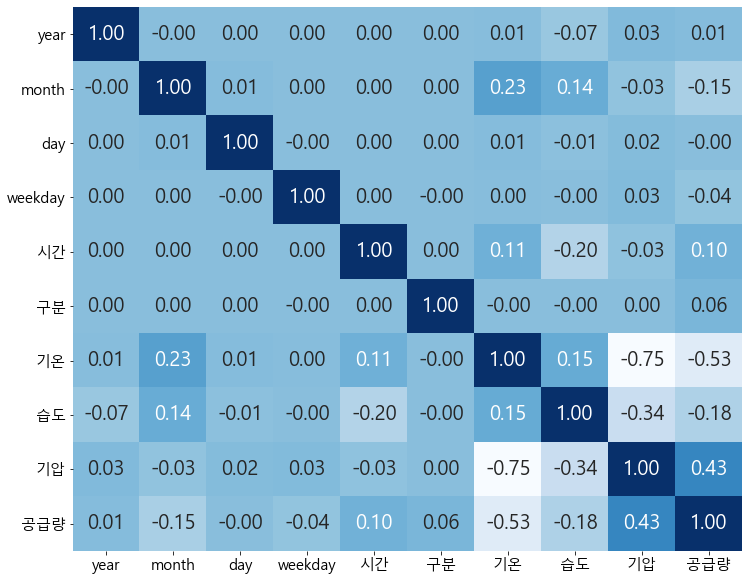

In [8]:
plt.figure(figsize=(12,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.heatmap(total[['year','month', 'day', 'weekday', '시간', '구분', '기온','습도','기압','공급량']].corr(), cmap='Blues', annot=True, fmt='.2f', cbar=False, annot_kws={"size": 20})

(array([ 1631., 12285., 32193., 47222., 53382., 56679., 58002., 46487.,
        38262., 21945.]),
 array([  7. ,  16.3,  25.6,  34.9,  44.2,  53.5,  62.8,  72.1,  81.4,
         90.7, 100. ]),
 <BarContainer object of 10 artists>)

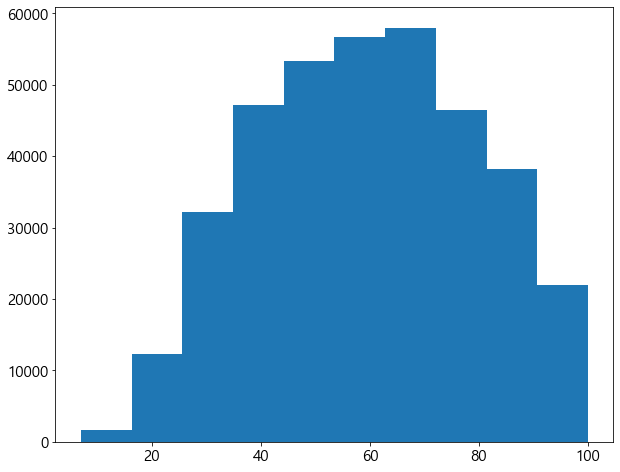

In [9]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='습도', data=total)

(array([  420.,  1414.,  9597., 43568., 77329., 70378., 79037., 60480.,
        23170.,  2695.]),
 array([ 976.5 ,  981.68,  986.86,  992.04,  997.22, 1002.4 , 1007.58,
        1012.76, 1017.94, 1023.12, 1028.3 ]),
 <BarContainer object of 10 artists>)

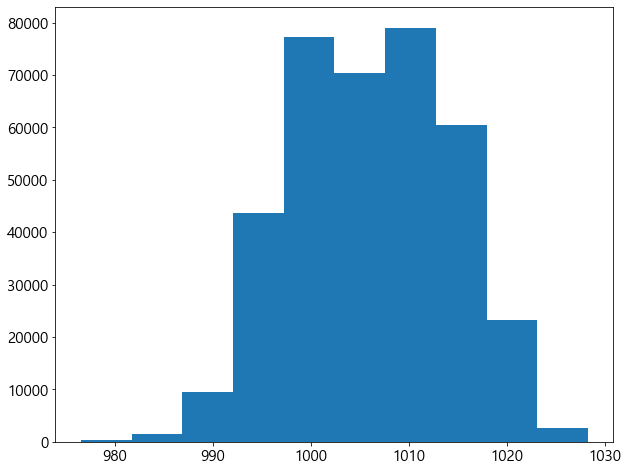

In [10]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='기압', data=total)

(array([ 1708., 12180., 36729., 52906., 48832., 49889., 64701., 73080.,
        26040.,  2023.]),
 array([-18.  , -12.26,  -6.52,  -0.78,   4.96,  10.7 ,  16.44,  22.18,
         27.92,  33.66,  39.4 ]),
 <BarContainer object of 10 artists>)

C:\Users\kbjoo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kbjoo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


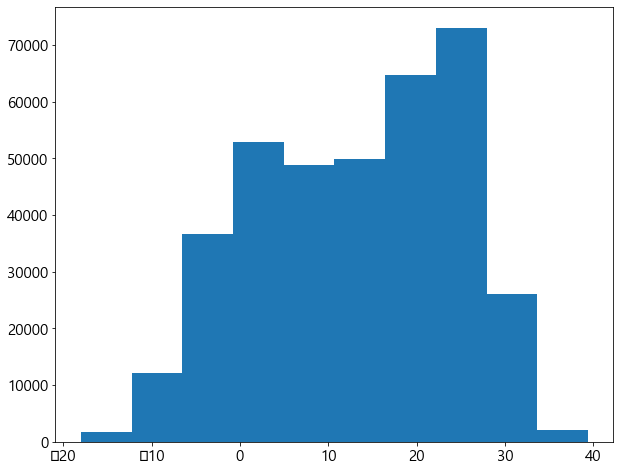

In [11]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='기온', data=total)

(array([2.56069e+05, 7.60110e+04, 2.76280e+04, 7.43600e+03, 8.86000e+02,
        5.30000e+01, 2.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([1.37800000e+00, 1.16060190e+03, 2.31982580e+03, 3.47904970e+03,
        4.63827360e+03, 5.79749750e+03, 6.95672140e+03, 8.11594530e+03,
        9.27516920e+03, 1.04343931e+04, 1.15936170e+04]),
 <BarContainer object of 10 artists>)

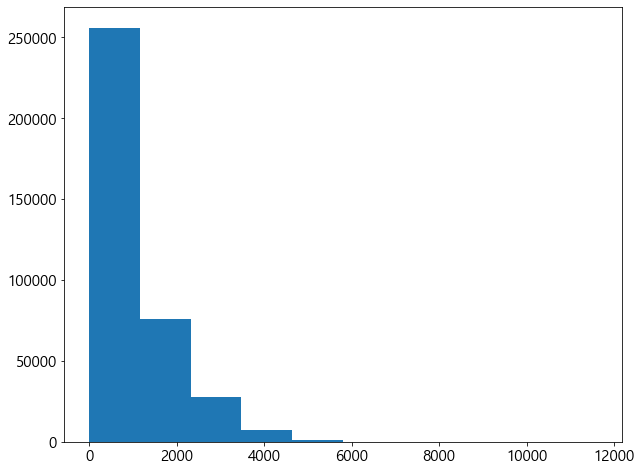

In [12]:
plt.figure(figsize=(10,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hist(x='공급량', data=total)

C:\Users\kbjoo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kbjoo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 864x576 with 0 Axes>

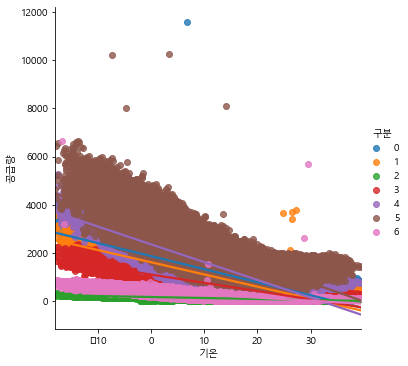

In [13]:
plt.figure(figsize=(12,8))
sns.lmplot(x='기온', y='공급량', hue='구분', data=total)

# 2019년 기온 예측하기
* 습도 예측
* 기압 예측

In [14]:
# !pip install pycaret

In [15]:
from pycaret.regression import *

## 습도(Humidity) 예측

In [16]:
# 학습 특성 : 'month', 'weekday', '시간'
# 타겟 특성 : '습도'

# 적용 특성 설정
exp = setup(total, target='습도', ignore_features=['공급량', 'year', 'day', '기온', '기압', '구분'],
            pca=True,
            polynomial_features=True, polynomial_degree=2)

,Description,Value
0,session_id,427
1,Target,습도
2,Original Data,"(368088, 10)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(257661, 1)"


In [17]:
# 모델 비교
start = time.time()

compare_models()

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,14.3646,311.3889,17.6461,0.2158,0.3315,0.2990,0.0810
et,Extra Trees Regressor,14.3646,311.3889,17.6461,0.2158,0.3315,0.2990,2.2310
rf,Random Forest Regressor,14.3644,311.3885,17.6461,0.2158,0.3315,0.2990,5.9270
lightgbm,Light Gradient Boosting Machine,14.3646,311.3889,17.6461,0.2158,0.3315,0.2990,0.9730
xgboost,Extreme Gradient Boosting,14.3646,311.3889,17.6461,0.2158,0.3315,0.2990,3.2270
gbr,Gradient Boosting Regressor,14.3685,311.4224,17.6471,0.2157,0.3315,0.2991,5.2170
catboost,CatBoost Regressor,14.3722,311.6234,17.6527,0.2152,0.3316,0.2992,17.5940
ada,AdaBoost Regressor,14.8250,322.1379,17.9481,0.1887,0.3440,0.3198,2.4350
knn,K Neighbors Regressor,15.7183,379.3993,19.4745,0.0443,0.3619,0.3235,5.9100
lr,Linear Regression,16.5378,390.8147,19.7689,0.0157,0.3752,0.3565,0.6450


0:07:35


### Top2 모델
* catboost
* lightgbm

In [ ]:
# lightgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# catboost 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lightgbm 모델 하이퍼파라미터 튜닝
start = time.time()

tuned_lgbm = tune_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# catboost 모델 하이퍼파라미터 튜닝
start = time.time()

tuned_cat = tune_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lgbm 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

humidity_prediction_lgbm = finalize_model(tuned_lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# cat 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

humidity_prediction_cat = finalize_model(tuned_cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lgbm 모델 습도 예측
start = time.time()

df = test2019[['month', 'weekday', '시간']]
humidity2019_pred_lgbm = predict_model(humidity_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# cat 모델 습도 예측
start = time.time()

df = test2019[['month', 'weekday', '시간']]
humidity2019_pred_cat = predict_model(humidity_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
humidity2019_pred_lgbm.head()

In [ ]:
humidity2019_pred_cat.head()

In [ ]:
# 두 모델 습도 예측 평균
humidity2019_pred = (humidity2019_pred_lgbm['Label'] + humidity2019_pred_cat['Label']) / 2
humidity2019_pred.head()

In [ ]:
test2019.head()

In [ ]:
# 2019년 예측 습도 열 추가
test2019['습도'] = humidity2019_pred
test2019.head()

## 기압 예측

In [ ]:
# 학습 특성 : 'month', 'weekday', '시간'
# 타겟 특성 : '기압'

exp = setup(total, target='기압', ignore_features=['공급량', 'year', 'day', '기온', '습도', '구분'])

In [ ]:
# 모델 비교
start = time.time()

compare_models()

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lightgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# catboost 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lightgbm 모델 하이퍼파라미터 튜닝
start = time.time()

tuned_lgbm = tune_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# cat 모델 하이퍼파라미터 튜닝
start = time.time()

tuned_cat = tune_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lgbm 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

pressure_prediction_lgbm = finalize_model(tuned_lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# cat 모델 훈련 완료(모든 샘플에 대해 재훈련)
start = time.time()

pressure_prediction_cat = finalize_model(tuned_cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lgbm 모델 기압 예측
start = time.time()

df = test2019[['month', 'weekday', '시간']]
pressure2019_pred_lgbm = predict_model(pressure_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# cat 모델 기압 예측
start = time.time()

df = test2019[['month', 'weekday', '시간']]
pressure2019_pred_cat = predict_model(pressure_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
pressure2019_pred_lgbm.head()

In [ ]:
pressure2019_pred_cat.head()

In [ ]:
# 두 모델 기압 예측 평균
pressure2019_pred = (pressure2019_pred_lgbm['Label'] + pressure2019_pred_cat['Label']) / 2

In [ ]:
pressure2019_pred.head()

In [ ]:
test2019.head()

In [ ]:
# 2019년 예측 기압 열 추가
test2019['기압'] = pressure2019_pred
test2019.head()

## 기온예측

In [ ]:
# 학습 특성 : 'month', 'weekday', '시간', '습도', '기압'
# 타겟 특성 : '기온'

exp = setup(total, target='기온', ignore_features=['공급량', 'year', 'day', '구분'])

In [ ]:
# 모델 비교
start = time.time()

compare_models()

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# cat 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lgbm 모델 하이퍼파라미터 튜닝
start = time.time()

tuned_lgbm = tune_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# cat 모델 하이퍼파라미터 튜닝
start = time.time()

tuned_cat = tune_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lgbm 훈련 완료(모든 샘플에 대한 재훈련)
start = time.time()

temp_prediction_lgbm = finalize_model(tuned_lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# cat 훈련 완료(모든 샘플에 대한 재훈련)
start = time.time()

temp_prediction_cat = finalize_model(tuned_cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lgbm 기온 예측
start = time.time()

df = test2019[['month', 'weekday', '시간', '습도', '기압']]
temp2019_pred_lgbm = predict_model(temp_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# cat 기온 예측
start = time.time()

df = test2019[['month', 'weekday', '시간', '습도', '기압']]
temp2019_pred_cat = predict_model(temp_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
temp2019_pred_lgbm.head()

In [ ]:
temp2019_pred_cat.head()

In [ ]:
# 두 모델 기온 예측 평균
temp2019_pred = (temp2019_pred_lgbm['Label'] + temp2019_pred_cat['Label']) / 2

In [ ]:
test2019.head()

In [ ]:
# 2019년 예측 기온 열 추가
test2019['기온'] = temp2019_pred
test2019.head()

### 가스 공급량 예측

In [ ]:
import numpy as np

In [ ]:
total['log_공급량'] = np.log1p(total['공급량'])
total.head()

In [ ]:
# 학습 특성 : 'month', 'weekday', '시간', '구분', '습도', '기압', '기온'
exp = setup(total, target='log_공급량', ignore_features=['year', '공급량', 'day'])

In [ ]:
# lgbm 모델 생성
start = time.time()

lgbm = create_model('lightgbm')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# cat 모델 생성
start = time.time()

cat = create_model('catboost')

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lgbm 튜닝
start = time.time()

tuned_lgbm = tune_model(lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# cat 튜닝
start = time.time()

tuned_cat = tune_model(cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lgbm 훈련 완료
start = time.time()

gas_prediction_lgbm = finalize_model(tuned_lgbm)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# cat 훈련 완료
start = time.time()

gas_prediction_cat = finalize_model(tuned_cat)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# lgbm log_공급량 예측
start = time.time()

df = test2019[['month', 'weekday', '시간', '구분', '습도', '기압', '기온']]
log_gas2019_pred_lgbm = predict_model(gas_prediction_lgbm, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
# cat log_공급량 예측
start = time.time()

df = test2019[['month', 'weekday', '시간', '구분', '습도', '기압', '기온']]
log_gas2019_pred_cat = predict_model(gas_prediction_cat, data=df)

end = time.time()
sec = end - start
result = datetime.timedelta(seconds=sec)
print(str(result).split('.')[0])

In [ ]:
log_gas2019_pred_lgbm.head()

In [ ]:
log_gas2019_pred_cat.head()

In [ ]:
# lgbm log_공급량 값을 공급량 값으로 변환
gas_pred2019_lgbm = np.expm1(log_gas2019_pred_lgbm['Label'])
gas_pred2019_lgbm.head()

In [ ]:
# cat log_공급량 값을 공급량 값으로 변환
gas_pred2019_cat = np.expm1(log_gas2019_pred_cat['Label'])
gas_pred2019_cat.head()

In [ ]:
# 두 모델 공급량 예측 평균
gas2019_pred = (gas_pred2019_lgbm + gas_pred2019_cat) / 2
gas2019_pred.head()

### 제출 파일 만들기

In [ ]:
sub = pd.read_csv('../data/sample_submission.csv')
sub.head()

In [ ]:
sub['공급량'] = gas2019_pred
sub.head()

In [ ]:
sub.info()

In [ ]:
sub.to_csv("sub18_pycaret06.csv", index=False)